In [ ]:
import numpy as np
from scipy.optimize import least_squares
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import savgol_filter 


def yearfrac(start_date, end_dates):
    start = datetime.strptime(start_date, '%d-%b-%Y')
    return np.array([(datetime.strptime(date, '%d-%b-%Y') - start).days / 365.25 for date in end_dates])

def sabr_vol(alpha, beta, rho, nu, F, K, T):
    if F == K:
        z = 0
    else:
        z = (nu / alpha) * (F * K)**((1 - beta) / 2) * np.log(F / K)
    
    x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))

    if z == 0:
        vol = alpha * (F * K)**((beta - 1) / 2)
    else:
        vol = alpha * (F * K)**((beta - 1) / 2) * (z / x_z)
    
    term1 = ((1 - beta)**2 / 24) * (np.log(F / K))**2
    term2 = 0.25 * rho * beta * nu * alpha * (F * K)**((1 - beta) / 2)
    term3 = (2 - 3 * rho**2) * (nu**2 / 24)
    
    vol = vol * (1 + (term1 + term2 + term3) * T)
    
    return vol

Settle = '12-Jun-2013'
ExerciseDates = [
    '12-Sep-2013', '12-Jun-2014', '12-Jun-2015', '12-Jun-2016', '12-Jun-2017',
    '12-Jun-2018', '12-Jun-2020', '12-Jun-2023'
]

YearsToExercise = yearfrac(Settle, ExerciseDates)
NumMaturities = len(YearsToExercise)


MarketVolatilities = np.array([
    [61.2, 58.1, 54.0, 50.0, 48.3, 45.1, 39.1, 36.2],
    [50.2, 50.5, 48.4, 45.2, 43.3, 40.9, 36.8, 34.4],
    [39.6, 43.0, 43.4, 41.7, 40.9, 38.3, 34.0, 32.3],
    [38.1, 40.5, 41.7, 40.5, 39.0, 35.8, 31.8, 30.2],
    [45.0, 45.3, 43.4, 41.6, 40.0, 36.6, 32.9, 30.0],
    [49.8, 47.4, 45.9, 43.2, 40.8, 37.1, 33.4, 30.1],
    [54.3, 50.9, 48.0, 44.0, 41.5, 37.8, 34.2, 31.2]
]) / 100  


MarketStrikes = np.array([
    [1.05, 1.30, 1.73, 2.05, 2.31, 2.46, 2.63, 2.67],
    [1.55, 1.80, 2.23, 2.55, 2.81, 2.96, 3.13, 3.17],
    [2.05, 2.30, 2.73, 3.05, 3.31, 3.46, 3.63, 3.67],
    [2.55, 2.80, 3.23, 3.55, 3.81, 3.96, 4.13, 4.17],
    [3.05, 3.30, 3.73, 4.05, 4.31, 4.46, 4.63, 4.67],
    [3.55, 3.80, 4.23, 4.55, 4.81, 4.96, 5.13, 5.17],
    [4.05, 4.30, 4.73, 5.05, 5.31, 5.46, 5.63, 5.67]
]) / 100  



CurrentForwardValues = MarketStrikes[3, :]
Beta = 0.5
Betas = np.full(NumMaturities, Beta)
Alphas = np.zeros(NumMaturities)
Rhos = np.zeros(NumMaturities)
Nus = np.zeros(NumMaturities)

for k in range(NumMaturities):
    def alpharoots(Rho, Nu):
        coeffs = [
            (1 - Beta)**2 * YearsToExercise[k] / 24 / CurrentForwardValues[k]**(2 - 2 * Beta),
            Rho * Beta * Nu * YearsToExercise[k] / 4 / CurrentForwardValues[k]**(1 - Beta),
            1 + (2 - 3 * Rho**2) * Nu**2 * YearsToExercise[k] / 24,
            -MarketVolatilities[3, k] * CurrentForwardValues[k]**(1 - Beta)
        ]
        return np.roots(coeffs)

    def atmVol2SabrAlpha(Rho, Nu):
        roots = alpharoots(Rho, Nu)
        real_roots = [root.real for root in roots if np.isreal(root) and root > 0]
        return min(real_roots) if real_roots else np.inf

    def objFun(X):
        Rho, Nu = X
        Alpha = atmVol2SabrAlpha(Rho, Nu)
        return MarketVolatilities[:, k] - [
            sabr_vol(Alpha, Beta, Rho, Nu, CurrentForwardValues[k], MarketStrikes[j, k], YearsToExercise[k])
            for j in range(len(MarketStrikes))
        ]

    res = least_squares(objFun, [0, 0.5], bounds=([-1, 0], [1, np.inf]))
    Rho, Nu = res.x

    Alpha = atmVol2SabrAlpha(Rho, Nu)

    Alphas[k] = Alpha
    Rhos[k] = Rho
    Nus[k] = Nu


CalibratedParameters = pd.DataFrame({
    'Alpha': Alphas,
    'Beta': Betas,
    'Rho': Rhos,
    'Nu': Nus
}, index=[
    '3M into 10Y', '1Y into 10Y', '2Y into 10Y', '3Y into 10Y',
    '4Y into 10Y', '5Y into 10Y', '7Y into 10Y', '10Y into 10Y'
])

print(CalibratedParameters)


                 Alpha  Beta       Rho        Nu
3M into 10Y   0.058378   0.5  0.395682  1.478466
1Y into 10Y   0.060344   0.5  0.291661  1.206966
2Y into 10Y   0.063127   0.5  0.232806  1.033704
3Y into 10Y   0.062868   0.5  0.197438  0.894097
4Y into 10Y   0.060887   0.5  0.139481  0.839282
5Y into 10Y   0.056257   0.5  0.075794  0.780711
7Y into 10Y   0.049101   0.5  0.096193  0.718873
10Y into 10Y  0.048920   0.5  0.045084  0.545628


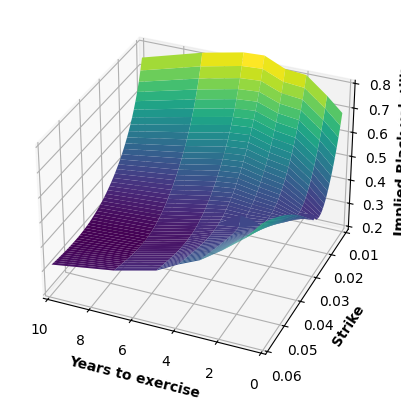

In [39]:
# Plot de la surface de volatilité 
PlottingStrikes = np.arange(0.95, 5.9, 0.1) / 100
ComputedVols = np.zeros((len(PlottingStrikes), NumMaturities))


for k in range(NumMaturities):
    ComputedVols[:, k] = [sabr_vol(Alphas[k], Betas[k], Rhos[k], Nus[k], 
                                   CurrentForwardValues[k], strike, YearsToExercise[k]) 
                          for strike in PlottingStrikes]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(YearsToExercise, PlottingStrikes)
Z = ComputedVols

surf = ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlim([0, 10])
ax.set_ylim([0.0095, 0.06])
ax.set_zlim([0.2, 0.8])

ax.set_xlabel('Years to exercise', fontweight='bold')
ax.set_ylabel('Strike', fontweight='bold')
ax.set_zlabel('Implied Black volatility', fontweight='bold')

ax.view_init(elev=32, azim=113)

plt.show()


In [40]:

# On définit les paramètres de notre swaption 

SwaptionSettle = '2013-06-12'
SwaptionExerciseDate = '2018-06-12'
SwapMaturity = '2028-06-12'
Reset = 1
OptSpec = 'call'
Strike = 0.0278 #On définit un strike price arbitraire


ValuationDate = '2013-06-12'
EndDates = [
    '2013-07-12', '2013-09-12', '2013-12-12', '2014-06-12',
    '2015-06-12', '2016-06-12', '2017-06-12', '2018-06-12',
    '2019-06-12', '2020-06-12', '2021-06-12', '2022-06-12',
    '2023-06-12', '2025-06-12', '2028-06-12', '2033-06-12'
]


Rates = np.array([0.25, 0.35, 0.45, 0.8, 0.6, 0.8, 1.2, 1.6, 1.9, 2.2,
                  2.4, 2.6, 2.8, 3.1, 3.4, 3.6]) / 100

Compounding = 1

# Fonction pour calculer les intervalles de temps 
def yearfrac(start_date, end_dates, basis=1):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    year_fractions = []
    for end_date in end_dates:
        end = datetime.strptime(end_date, "%Y-%m-%d")
        diff = relativedelta(end, start)
        if basis == 1:  # Actual/Actual
            yf = diff.years + diff.months / 12 + diff.days / 365
        year_fractions.append(yf)
    return np.array(year_fractions)


YearFractions = yearfrac(ValuationDate, EndDates)

# On créer un dataframe avec les caractéristiques de notre swaption

RateSpec = pd.DataFrame({
    'ValuationDate': [ValuationDate] * len(EndDates),
    'StartDates': [ValuationDate] * len(EndDates),
    'EndDates': EndDates,
    'Rates': Rates,
    'Compounding': [Compounding] * len(EndDates)
})


print(RateSpec)


   ValuationDate  StartDates    EndDates   Rates  Compounding
0     2013-06-12  2013-06-12  2013-07-12  0.0025            1
1     2013-06-12  2013-06-12  2013-09-12  0.0035            1
2     2013-06-12  2013-06-12  2013-12-12  0.0045            1
3     2013-06-12  2013-06-12  2014-06-12  0.0080            1
4     2013-06-12  2013-06-12  2015-06-12  0.0060            1
5     2013-06-12  2013-06-12  2016-06-12  0.0080            1
6     2013-06-12  2013-06-12  2017-06-12  0.0120            1
7     2013-06-12  2013-06-12  2018-06-12  0.0160            1
8     2013-06-12  2013-06-12  2019-06-12  0.0190            1
9     2013-06-12  2013-06-12  2020-06-12  0.0220            1
10    2013-06-12  2013-06-12  2021-06-12  0.0240            1
11    2013-06-12  2013-06-12  2022-06-12  0.0260            1
12    2013-06-12  2013-06-12  2023-06-12  0.0280            1
13    2013-06-12  2013-06-12  2025-06-12  0.0310            1
14    2013-06-12  2013-06-12  2028-06-12  0.0340            1
15    20

In [ ]:
def compute_forward_swap_rate(RateSpec, LegRate, SwaptionSettle, SwaptionExerciseDate):
    forward_swap_rate = RateSpec.loc[RateSpec['EndDates'] == SwaptionExerciseDate, 'Rates'].values[0]
    return forward_swap_rate

# On calcule le forward swap rate
LegRate = [np.nan, 0] 
CurrentForwardSwapRate = compute_forward_swap_rate(RateSpec, LegRate, SwaptionSettle, SwaptionExerciseDate)

# On utilise la volatilité SABR pour calculer la volatillité implicite
def blackvolbysabr(alpha, beta, rho, nu, SwaptionSettle, SwaptionExerciseDate, forward_swap_rate, strike):
    T = yearfrac(SwaptionSettle, [SwaptionExerciseDate])[0]
    volatility = sabr_vol(alpha, beta, rho, nu, forward_swap_rate, strike, T) 
    return volatility


# On spécifie une maturité pour lequel on récupère les paramètres du modèle (ici 5)
SABRBlackVolatility = blackvolbysabr(Alphas[5], Betas[5], Rhos[5], Nus[5], SwaptionSettle, SwaptionExerciseDate, CurrentForwardSwapRate, Strike)


print(f"Current Forward Swap Rate: {CurrentForwardSwapRate:.4f}")
print(f"SABR Black Volatility: {SABRBlackVolatility:.4f}")


Current Forward Swap Rate: 0.0160
SABR Black Volatility: 0.5847


In [42]:

T = yearfrac(SwaptionSettle, [SwaptionExerciseDate])[0]
Notional = 1000

def black_scholes_price(F, K, T, sigma, opt_type="call", notional=1):

    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if opt_type == "call":
        option_price = np.exp(-0 * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))  
        option_price = np.exp(-0 * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    else:
        raise ValueError("Option type must be 'call' or 'put'.")
    
    price = option_price * notional
    
    return price

Price = black_scholes_price(CurrentForwardSwapRate, Strike, T, SABRBlackVolatility, OptSpec, Notional)
print(f"Swaption price: {Price:.4f}")

Swaption price: 17.3455


Cette partie est indépendante du reste du code, on réutilise la fonction sabr_vol pour étudier l'influence des paramètres du modèle sur la courbe de la volatilité en fonction du strike

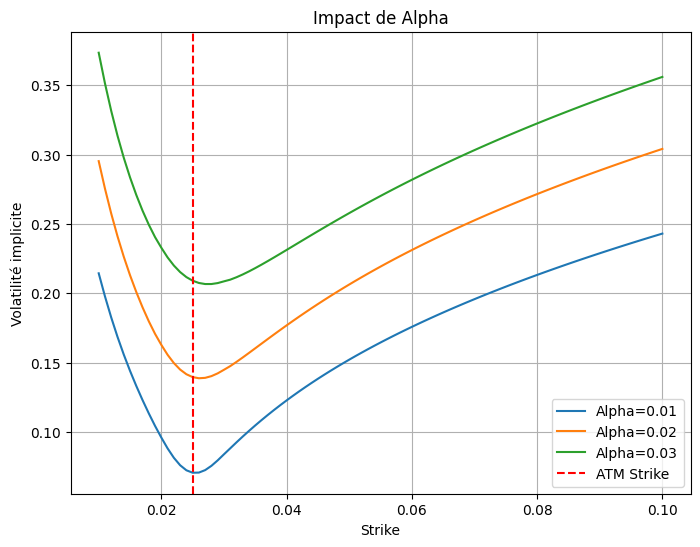

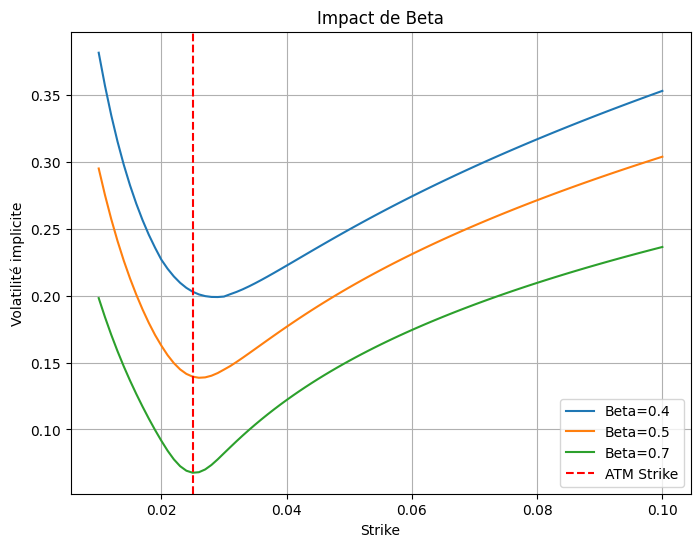

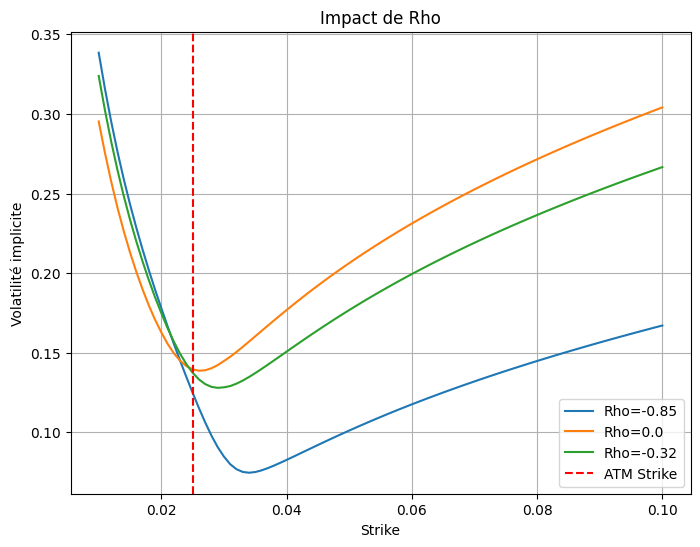

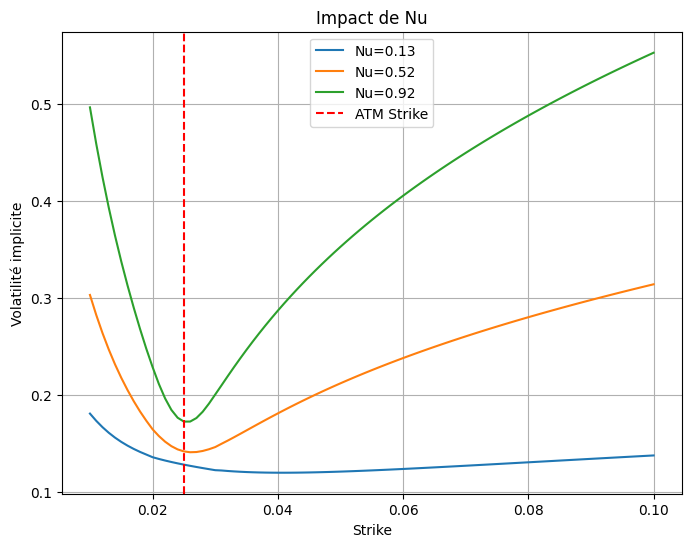

In [43]:

F = 0.025  # On fixe un forward rate 
T = 5  # Maturité en années (exemple)
K_values = np.arange(0.01, 0.1, 0.001)  # Valeurs de strike

# On fixe des paramètres arbitrairement
alpha_base = 0.02
beta_base = 0.5
rho_base = 0.0
nu_base = 0.5


params_to_vary = {
    'Alpha': [0.01, 0.02, 0.03], 
    'Beta': [0.4, 0.5, 0.7],       
    'Rho': [-0.85, 0.0, -0.32],   
    'Nu': [0.13, 0.52, 0.92]      
}

def plot_graph(x_values, y_values, title, xlabel, ylabel, atm_strike, param_label):
    plt.figure(figsize=(8, 6))
    for y, label in y_values:
        plt.plot(x_values, y, label=label)
    plt.axvline(x=atm_strike, color='red', linestyle='--', label='ATM Strike')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Alpha : variation avec Beta, Rho, Nu fixés
y_values_alpha = []
for alpha in params_to_vary['Alpha']:
    vols = [sabr_vol(alpha, beta_base, rho_base, nu_base, F, K, T) for K in K_values]
    vols_smoothed = savgol_filter(vols, window_length=11, polyorder=3)  # Lissage avec fenêtre de 11 et ordre 3
    y_values_alpha.append((vols_smoothed, f'Alpha={alpha}'))
plot_graph(K_values, y_values_alpha, 'Impact de Alpha', 'Strike', 'Volatilité implicite', F, 'Alpha')

# Beta : variation avec Alpha, Rho, Nu fixés
y_values_beta = []
for beta in params_to_vary['Beta']:
    vols = [sabr_vol(alpha_base, beta, rho_base, nu_base, F, K, T) for K in K_values]
    vols_smoothed = savgol_filter(vols, window_length=11, polyorder=3)
    y_values_beta.append((vols_smoothed, f'Beta={beta}'))
plot_graph(K_values, y_values_beta, 'Impact de Beta', 'Strike', 'Volatilité implicite', F, 'Beta')

# Rho : variation avec Alpha, Beta, Nu fixés
y_values_rho = []
for rho in params_to_vary['Rho']:
    vols = [sabr_vol(alpha_base, beta_base, rho, nu_base, F, K, T) for K in K_values]
    vols_smoothed = savgol_filter(vols, window_length=11, polyorder=3)
    y_values_rho.append((vols_smoothed, f'Rho={rho}'))
plot_graph(K_values, y_values_rho, 'Impact de Rho', 'Strike', 'Volatilité implicite', F, 'Rho')

# Nu : variation avec Alpha, Beta, Rho fixés
y_values_nu = []
for nu in params_to_vary['Nu']:
    vols = [sabr_vol(alpha_base, beta_base, rho_base, nu, F, K, T) for K in K_values]
    vols_smoothed = savgol_filter(vols, window_length=11, polyorder=3)
    y_values_nu.append((vols_smoothed, f'Nu={nu}'))
plot_graph(K_values, y_values_nu, 'Impact de Nu', 'Strike', 'Volatilité implicite', F, 'Nu')
